**1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

In [55]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [56]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [57]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [58]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [59]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [60]:
def residual(y, z):
    return - (z - y)

In [61]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

**Проведём испытания модели по сетке по кол-ву деревьев и глубине с фиксацией ошибок на трэин и тест выборках**

In [62]:
num_trees = np.array([1, 5, 10, 20, 30, 50])
depth = np.array([1, 3, 5, 7, 10])
num_trees, depth = np.meshgrid(num_trees, depth)
eta = 0.1
train_err = np.zeros(num_trees.shape)
test_err = np.zeros(num_trees.shape)
for row in range(num_trees.shape[0]):
    for col in range(num_trees.shape[1]):
        trees, train_errors, test_errors = gb_fit(num_trees[row][col], depth[row][col], X_train, X_test, y_train, y_test, eta)
        train_err[row][col] = train_errors[-1]
        test_err[row][col] = test_errors[-1]

**Отрисуем зависимости ошибок на трэин и тест выборках от глубины обучения и кол-ва деревьев**

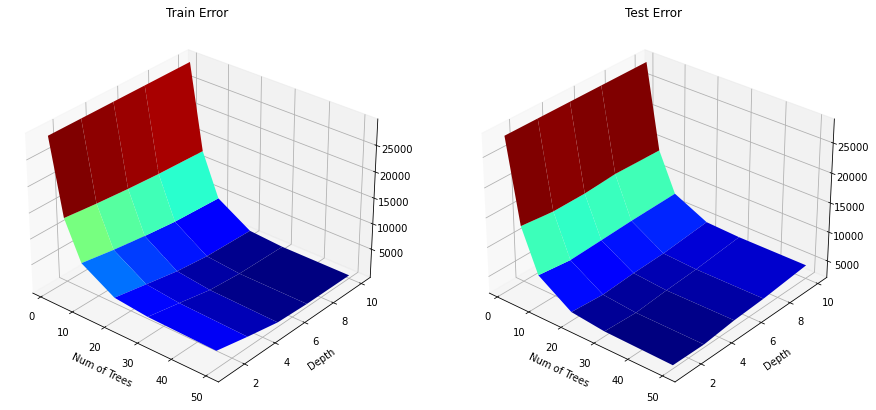

In [63]:
fig = plt.figure(figsize=(15, 8))
axes1 = fig.add_subplot(1, 2, 1, projection='3d')
axes2 = fig.add_subplot(1, 2, 2, projection='3d')


axes1.plot_surface(num_trees, depth, train_err, cmap='jet')
axes1.set_title("Train Error")
axes1.set_xlabel('Num of Trees')
axes1.set_ylabel('Depth')
axes1.view_init(30, -50)


axes2.plot_surface(num_trees, depth, test_err, cmap='jet')
axes2.set_title("Test Error")
axes2.set_xlabel('Num of Trees')
axes2.set_ylabel('Depth')
axes2.view_init(30, -50)

plt.show()

По полученным графикам видно, что увеличение кол-ва деревьев на обеих выборках уменьшает ошибку. При этом увеличение глубины уменьшает ошибку на Train выборке, но увеличивает на Test (что логично - переобучение). Так что во избежание переобучения глубину лучше ставить минимальную, а кол-во деревьев - максимальное (в разумных пределах)

**2.Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

In [65]:
def sb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [66]:
def sb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
#ИЗМЕНЕНИЕ генерируем подвыборку Х и Y из x_train, y_train равные половине этих массивов        
        X = []
        Y = []

        ind = np.random.choice(range(0, X_train.shape[0]), size=int(0.5*X_train.shape[0]), replace=False)
        for i in ind:
            X.append(X_train[i])
            Y.append(y_train[i])
            
        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
#ИЗМЕНЕНИЕ  # обучаем первое дерево на половине обучающей выборки
            tree.fit(X, Y)
            
            train_errors.append(mean_squared_error(y_train, sb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, sb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = sb_predict(X, trees, eta)
            
#ИЗМЕНЕНИЕ  # алгоритмы начиная со второго обучаем на сдвиг на половине выборки
            tree.fit(X, residual(Y, target))
            
            train_errors.append(mean_squared_error(y_train, sb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, sb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [67]:
num_trees = 50
depth = 3
trees, train_errors, test_errors = sb_fit(num_trees, depth, X_train, X_test, y_train, y_test, eta)

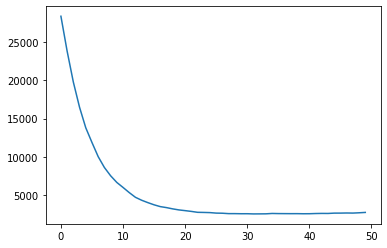

In [68]:
plt.plot(range(len(test_errors)), test_errors)

plt.show()

С увеличением кол-ва итераций ошибка уменьшается в целом, особенно вначале<br> При этом если присмотреться к хвостику, будет заметно, что ошибка уменьшается не равномерно, что характерно для стохастики

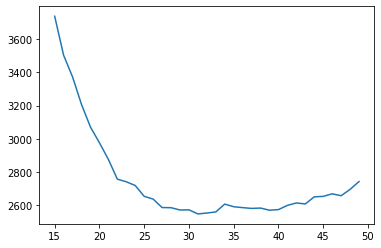

In [69]:
plt.plot(range(len(test_errors))[15:], test_errors[15:])

plt.show()